## Objective:
A hospital in the province of Greenland has been trying to improve its care conditions by looking at historic survival of the patients. They tried looking at their data but could not identify the main factors leading to high survivals.

Need to develop a model that will predict the chances of survival of a patient after 1 year of treatment (Survived_1_year).

## Dataset:
The dataset contains the patient records collected from a hospital in Greenland. The "Survived_1_year" column is a target variable which has binary entries (0 or 1).

    Survived_1_year == 0, implies that the patient did not survive after 1 year of treatment.
    Survived_1_year == 1, implies that the patient survived after 1 year of treatment.
 
 Training Dataset location: 'https://raw.githubusercontent.com/dphi-official/Datasets/master/pharma_data/Training_set_begs.csv'
 
 Test Dataset location: 'https://raw.githubusercontent.com/dphi-official/Datasets/master/pharma_data/Testing_set_begs.csv'

## Data Description:

1. ID_Patient_Care_Situation: Care situation of a patient during treatment
2. Diagnosed_Condition: The diagnosed condition of the patient
3. ID_Patient: Patient identifier number
4. Treatment_with_drugs: Class of drugs used during treatment
5. Survived_1_year: If the patient survived after one year (0 means did not survive; 1 means survived)
6. Patient_Age: Age of the patient
7. Patient_Body_Mass_Index: A calculated value based on the patient’s weight, height, etc.
8. Patient_Smoker: If the patient was a smoker or not
9. Patient_Rural_Urban: If the patient stayed in Rural or Urban part of the country
10. Patient_mental_condition:
11. Previous_Condition: Condition of the patient before the start of the treatment ( This variable is splitted into 8 columns - A, B, C, D, E, F, Z and Number_of_prev_cond. A, B, C, D, E, F and Z are the previous conditions of the patient. Suppose for one patient, if the entry in column A is 1, it means that the previous condition of the patient was A. If the patient didn't have that condition, it is 0 and same for other conditions. If a patient has previous condition as A and C , columns A and C will have entries as 1 and 1 respectively while the other column B, D, E, F, Z will have entries 0, 0, 0, 0, 0 respectively. The column Number_of_prev_cond will have entry as 2 i.e. 1 + 0 + 1 + 0 + 0 + 0 + 0 + 0 = 2 in this case. )

### Approach and strategy:
   #### Step 1: Data Cleansing and Feature engineering: 
         => Remove the ID columns: "ID_Patient_Care_Situation" and "ID_Patient".
         => Check for Nulls and fix appropriately: 
                   Impute columns A to Z with mode. Previous_Condition with sum of A to Z. Remove Null Treatment_with_drugs.
         => Replace variable "Treatment_with_drugs" with 6 Unique Drug variables.
         => Remove single value columns.
         => Remove calculated Variable "Previous_Condition"
         => Convert categorical variables into numeric by one hot/label encoding accordingly.
         => Scale the columns.
After renaming the columns for convenience final dataframe before scaling will be:          
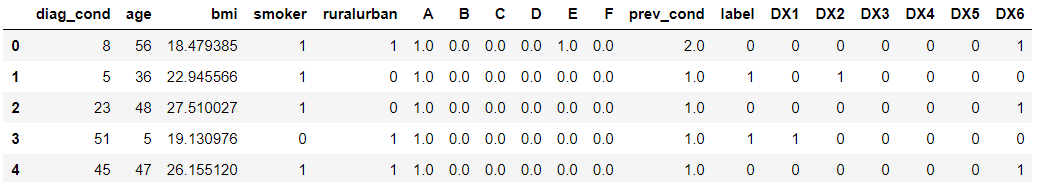
    


   #### Step 2: Model Building and evaluation:
       => Split the training set into train and test.
       => Use the splitted test data for checking if overfitting or under fitting.
       => Try different models. Try to tune hyper parameter for getting maximum f1 score on hidden test data.
       => Grid Search CV can be used but observation I have is, although it shows best params for the test data (splitted from training set), they wont be best for the hidden test data. Main concern is it takes longer time.
       => Using for loops, created my own grid search (kind of), where it gives the predicted values for each iteration so that it can be checked against the hidden test data. Playing around the best params will fetch 'THE' best params.
            
Following is the the iteration table for XG Boosting algorithm:
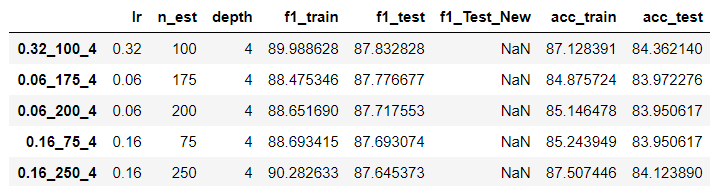

Iteration table is sorted with f1_test, for each of the param combination, f1 on Test (hidden) set is calculated by quering the predicted values on the portal.
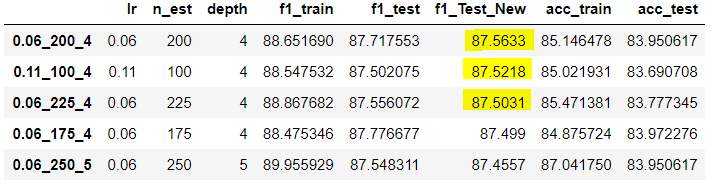

Playing around the params for the highest f1 scores, gave best personal submission.
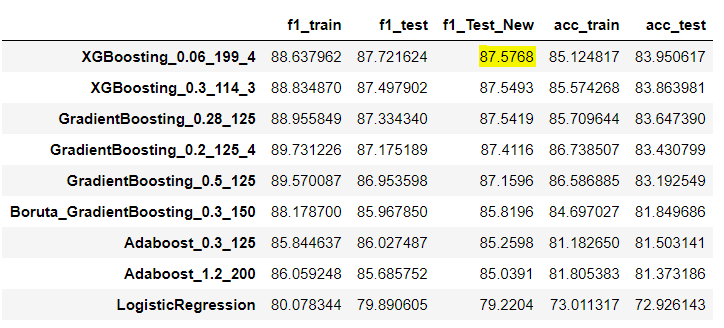

#### Load the required libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#### Load the training as well as test dataset

In [2]:
pharma_data = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/pharma_data/Training_set_begs.csv')
print('Shape:',pharma_data.shape)
pharma_data.head()

Shape: (23097, 18)


,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Patient_mental_condition,A,B,C,D,E,F,Z,Number_of_prev_cond,Survived_1_year
0,22374,8,3333,DX6,56,18.479385,YES,URBAN,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
1,18164,5,5740,DX2,36,22.945566,YES,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,6283,23,10446,DX6,48,27.510027,YES,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,5339,51,12011,DX1,5,19.130976,NO,URBAN,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,33012,0,12513,NaN,128,1.348400,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1


In [3]:
test_new = pd.read_csv('https://raw.githubusercontent.com/dphi-official/Datasets/master/pharma_data/Testing_set_begs.csv')
print('Shape:',test_new.shape)
test_new.head()

Shape: (9303, 17)


,ID_Patient_Care_Situation,Diagnosed_Condition,Patient_ID,Treated_with_drugs,Patient_Age,Patient_Body_Mass_Index,Patient_Smoker,Patient_Rural_Urban,Patient_mental_condition,A,B,C,D,E,F,Z,Number_of_prev_cond
0,19150,40,3709,DX3,16,29.443894,NO,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
1,23216,52,986,DX6,24,26.836321,NO,URBAN,Stable,1.0,1.0,0.0,0.0,0.0,0.0,0.0,2.0
2,11890,50,11821,DX4 DX5,63,25.523280,NO,RURAL,Stable,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0
3,7149,32,3292,DX6,42,27.171155,NO,URBAN,Stable,1.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0
4,22845,20,9959,DX3,50,25.556192,NO,RURAL,Stable,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Simplifying the column names for convenience

In [8]:
pharma_data.columns=['care_situation', 'diag_cond', 'id',
       'drugs', 'age', 'bmi',
       'smoker', 'ruralurban', 'mental',
       'A', 'B', 'C', 'D', 'E', 'F', 'Z', 'prev_cond',
       'label']
test_new.columns=['care_situation', 'diag_cond', 'id',
       'drugs', 'age', 'bmi',
       'smoker', 'ruralurban', 'mental',
       'A', 'B', 'C', 'D', 'E', 'F', 'Z', 'prev_cond']

#### Check for Nulls.

In [9]:
pharma_data.isnull().sum()

care_situation       0
diag_cond            0
id                   0
drugs               13
age                  0
bmi                  0
smoker               0
ruralurban           0
mental               0
A                 1235
B                 1235
C                 1235
D                 1235
E                 1235
F                 1235
Z                 1235
prev_cond         1235
label                0
dtype: int64

In [10]:
test_new.isnull().sum()

care_situation    0
diag_cond         0
id                0
drugs             0
age               0
bmi               0
smoker            0
ruralurban        0
mental            0
A                 0
B                 0
C                 0
D                 0
E                 0
F                 0
Z                 0
prev_cond         0
dtype: int64

##### Looks like Training dataset has nulls for columns drugs and A to Z and prev_cond

###### Drugs >

In [11]:
pharma_data[pharma_data.drugs.isnull()]

,care_situation,diag_cond,id,drugs,age,bmi,smoker,ruralurban,mental,A,B,C,D,E,F,Z,prev_cond,label
4,33012,0,12513,NaN,128,1.3484,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
218,33008,0,12509,NaN,112,1.2925,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2540,33014,0,12515,NaN,149,1.7784,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
2711,33004,0,12505,NaN,123,1.9290,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
4308,33001,0,12502,NaN,114,1.6239,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
4887,33011,0,12512,NaN,132,1.9896,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
6308,33010,0,12511,NaN,142,1.5701,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
10388,33006,0,12507,NaN,138,1.3745,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
10663,33009,0,12510,NaN,142,1.1450,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1
12782,33000,0,12501,NaN,112,1.5465,Cannot say,RURAL,Stable,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1


##### Age and BMI looks weird, lets plot AGE and BMI box plots to comfirm.

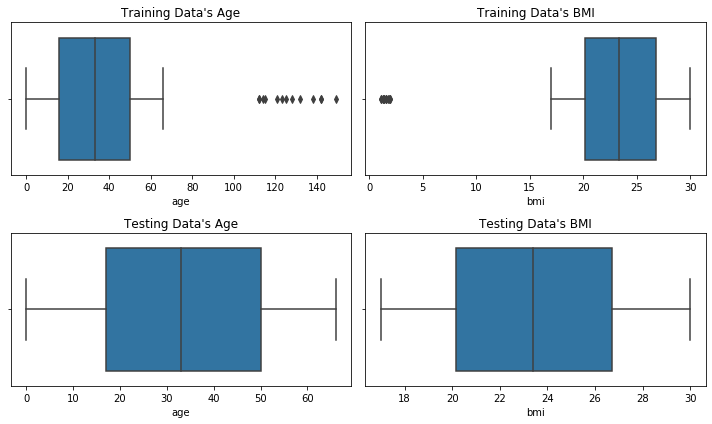

In [31]:
plt.figure(figsize=(10,6))
plt.subplot(2,2,1)
sns.boxplot(pharma_data.age)
plt.title("Training Data's Age")
plt.subplot(2,2,2)
sns.boxplot(pharma_data.bmi)
plt.title("Training Data's BMI")
plt.subplot(2,2,3)
sns.boxplot(test_new.age)
plt.title("Testing Data's Age")
plt.subplot(2,2,4)
sns.boxplot(test_new.bmi)
plt.title("Testing Data's BMI")
plt.tight_layout()
plt.show()

##### Looking at Training Data's age and bmi box-whisker plots, they seems to be outliers. We shall get rid of them.

###### A to Z >

In [726]:
pharma_data[pharma_data.A.isnull()]

,care_situation,diag_cond,id,drugs,age,bmi,smoker,ruralurban,mental,A,B,C,D,E,F,Z,prev_cond,label
27,4691,31,4500,DX2,44,27.935658,YES,URBAN,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
36,4869,28,6826,DX1,4,17.342624,NO,URBAN,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
41,32899,24,7275,DX2 DX5,12,20.994843,NO,RURAL,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
97,9311,13,7538,DX2,49,26.641499,NO,RURAL,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
105,13511,44,7903,DX4,41,28.079769,YES,RURAL,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23002,6195,3,7812,DX2,26,26.548517,YES,RURAL,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
23012,20220,48,12318,DX4,15,18.849124,NO,RURAL,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
23024,25571,6,3423,DX2,13,24.343030,NO,RURAL,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
23038,644,30,8032,DX3 DX5,45,19.272509,NO,RURAL,Stable,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


We shall replace with MODE for other missing values.

In [33]:
pharma_data.isnull().sum()[pharma_data.isnull().sum()>0].index[1:-1]

Index(['A', 'B', 'C', 'D', 'E', 'F', 'Z'], dtype='object')

In [34]:
for i in pharma_data.isnull().sum()[pharma_data.isnull().sum()>0].index[1:-1]:
    #print(i,':\n',pharma_data[i].value_counts(), pharma_data[i].mode())
    pharma_data[i].fillna(pharma_data[i].mode()[0],inplace=True)

In [35]:
pharma_data.isnull().sum()

care_situation       0
diag_cond            0
id                   0
drugs               13
age                  0
bmi                  0
smoker               0
ruralurban           0
mental               0
A                    0
B                    0
C                    0
D                    0
E                    0
F                    0
Z                    0
prev_cond         1235
label                0
dtype: int64

###### prev_cond >
According to the definition, prev_cond is sum of A to Z. Lets check if it holds good for rest of the data other than NAN data.

In [54]:
pharma_data[(~pharma_data.prev_cond.isnull()) & (pharma_data.prev_cond != (pharma_data.A+pharma_data.B+pharma_data.C+pharma_data.D+pharma_data.E+pharma_data.F++pharma_data.Z))]

,care_situation,diag_cond,id,drugs,age,bmi,smoker,ruralurban,mental,A,B,C,D,E,F,Z,prev_cond,label


As per the definition prev_cond is sum of A to Z. So replace prev_cond NAN with Sum of A to Z

In [53]:
pharma_data.prev_cond=pharma_data.A+pharma_data.B+pharma_data.C+pharma_data.D+pharma_data.E+pharma_data.F++pharma_data.Z

In [59]:
pharma_data[pharma_data.prev_cond==pharma_data.A+pharma_data.B+pharma_data.C+pharma_data.D+pharma_data.E+pharma_data.F++pharma_data.Z].prev_cond.count()

23097

prev_cond values looks good.

In [60]:
pharma_data.isnull().sum()

care_situation     0
diag_cond          0
id                 0
drugs             13
age                0
bmi                0
smoker             0
ruralurban         0
mental             0
A                  0
B                  0
C                  0
D                  0
E                  0
F                  0
Z                  0
prev_cond          0
label              0
dtype: int64

In [729]:
test_new.isnull().sum()

care_situation    0
diag_cond         0
id                0
drugs             0
age               0
bmi               0
smoker            0
ruralurban        0
mental            0
A                 0
B                 0
C                 0
D                 0
E                 0
F                 0
Z                 0
prev_cond         0
dtype: int64

Drop other NAN values i.e. the outliers discussed above.

In [61]:
pharma_data.dropna(inplace=True)
pharma_data.shape

(23084, 18)

#### ID columns (care_situation and id) can be removed.

In [62]:
print('Total rows in Training data:',len(pharma_data),'\n\t# of Unique ID:',pharma_data.id.nunique(), '\n\t# of Unique Case_Situation:',pharma_data.care_situation.nunique())
print('\nTotal rows in Testing data:',len(test_new),'\n\t# of Unique ID:',pharma_data.id.nunique(), '\n\t# of Unique Case_Situation:',pharma_data.care_situation.nunique())

Total rows in Training data: 23084 
	# of Unique ID: 10557 
	# of Unique Case_Situation: 23084

Total rows in Testing data: 9303 
	# of Unique ID: 10557 
	# of Unique Case_Situation: 23084


In [63]:
pharma_data.drop(['care_situation','id'],axis=1,inplace=True)
test_new.drop(['care_situation','id'],axis=1,inplace=True)

##### Columns 'mental' and 'Z' have just 1 unique value, we can get rid of these columns as well.

In [64]:
print('Training Data:','\n\t# of Unique "mental":',pharma_data.mental.nunique(), '\n\t# of Unique Z:',pharma_data.Z.nunique())
print('\nTesting Data:','\n\t# of Unique "mental":',test_new.mental.nunique(), '\n\t# of Unique Z:',test_new.Z.nunique())

Training Data: 
	# of Unique "mental": 1 
	# of Unique Z: 1

Testing Data: 
	# of Unique "mental": 1 
	# of Unique Z: 1


In [65]:
pharma_data.drop(['mental','Z'],axis=1,inplace=True)
test_new.drop(['mental','Z'],axis=1,inplace=True)

##### Check records:

In [66]:
print(pharma_data.shape)
pharma_data.head()

(23084, 14)


,diag_cond,drugs,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond,label
0,8,DX6,56,18.479385,YES,URBAN,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0
1,5,DX2,36,22.945566,YES,RURAL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,23,DX6,48,27.510027,YES,RURAL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,51,DX1,5,19.130976,NO,URBAN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
5,45,DX6,47,26.155120,YES,URBAN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0


##### As we had to delete few outlier records, lets reset the indexes.

In [67]:
pharma_data.reset_index(drop=True,inplace=True)
test_new.reset_index(drop=True,inplace=True)
pharma_data.head()

,diag_cond,drugs,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond,label
0,8,DX6,56,18.479385,YES,URBAN,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0
1,5,DX2,36,22.945566,YES,RURAL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
2,23,DX6,48,27.510027,YES,RURAL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0
3,51,DX1,5,19.130976,NO,URBAN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1
4,45,DX6,47,26.155120,YES,URBAN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0


In [68]:
test_new.head()

,diag_cond,drugs,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond
0,40,DX3,16,29.443894,NO,RURAL,1.0,0.0,0.0,0.0,1.0,0.0,2.0
1,52,DX6,24,26.836321,NO,URBAN,1.0,1.0,0.0,0.0,0.0,0.0,2.0
2,50,DX4 DX5,63,25.523280,NO,RURAL,1.0,0.0,0.0,0.0,1.0,0.0,2.0
3,32,DX6,42,27.171155,NO,URBAN,1.0,0.0,1.0,0.0,1.0,0.0,3.0
4,20,DX3,50,25.556192,NO,RURAL,1.0,0.0,0.0,0.0,0.0,0.0,1.0


##### Lets look at some categorical features.
1. 'drugs': 

In [739]:
pharma_data.drugs.unique()

array(['DX6', 'DX2 ', 'DX1 ', 'DX3 ', 'DX5 ', 'DX4 ', 'DX2 DX5 ',
       'DX2 DX3 ', 'DX1 DX3 ', 'DX1 DX2 ', 'DX3 DX4 ', 'DX1 DX4 ',
       'DX1 DX5 ', 'DX2 DX4 DX5 ', 'DX1 DX2 DX3 ', 'DX3 DX5 ', 'DX2 DX4 ',
       'DX3 DX4 DX5 ', 'DX2 DX3 DX5 ', 'DX1 DX2 DX3 DX4 ', 'DX4 DX5 ',
       'DX2 DX3 DX4 ', 'DX1 DX4 DX5 ', 'DX1 DX2 DX4 ', 'DX1 DX3 DX5 ',
       'DX1 DX2 DX5 ', 'DX1 DX3 DX4 ', 'DX1 DX3 DX4 DX5 ',
       'DX1 DX2 DX4 DX5 ', 'DX2 DX3 DX4 DX5 ', 'DX1 DX2 DX3 DX5 ',
       'DX1 DX2 DX3 DX4 DX5 '], dtype=object)

Looks like there are SIX Unique drugs which were given to patients in different combinations. Lets divide the 'drugs' variable into 6 different variable, such that each represents a unique drug. This also takes care of encoding.

The way we do this is, 
    
    a. We split up the drugs column using the blank space, this will make a list out of each observation.
    b. This each obseravation (list) is divided into 5 columns and stored into different DataFrame.
    c. We add DX1 to DX6 columns and value is calculated based on the 5 columns from step2.
    d. Concatenate DX1 to DX6 columns to the original dataframe.
    e. Housekeep the unneccessary columns.

##### Step a:

In [69]:
pharma_data['drugs_new']=pharma_data.drugs.str.split()
test_new['drugs_new']=test_new.drugs.str.split()

##### Step b:

In [70]:
df3 = pd.DataFrame(pharma_data['drugs_new'].to_list())
df4 = pd.DataFrame(test_new['drugs_new'].to_list())
df3.head()

,0,1,2,3,4
0,DX6,None,None,None,None
1,DX2,None,None,None,None
2,DX6,None,None,None,None
3,DX1,None,None,None,None
4,DX6,None,None,None,None


In [71]:
df4.head()

,0,1,2,3,4
0,DX3,None,None,None,None
1,DX6,None,None,None,None
2,DX4,DX5,None,None,None
3,DX6,None,None,None,None
4,DX3,None,None,None,None


##### Step c:

In [72]:
df3['DX1']=df3['DX2']=df3['DX3']=df3['DX4']=df3['DX5']=df3['DX6']=0
df3.columns=['D1', 'D2', 'D3', 'D4', 'D5', 'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6']

df3['DX1']= df3.D1.apply(lambda x: 1 if x=='DX1' else 0) + df3.D2.apply(lambda x: 1 if x=='DX1' else 0) +  df3.D3.apply(lambda x: 1 if x=='DX1' else 0) + df3.D4.apply(lambda x: 1 if x=='DX1' else 0) + df3.D5.apply(lambda x: 1 if x=='DX1' else 0)
df3['DX2']= df3.D1.apply(lambda x: 1 if x=='DX2' else 0) + df3.D2.apply(lambda x: 1 if x=='DX2' else 0) +  df3.D3.apply(lambda x: 1 if x=='DX2' else 0) + df3.D4.apply(lambda x: 1 if x=='DX2' else 0) + df3.D5.apply(lambda x: 1 if x=='DX2' else 0)
df3['DX3']= df3.D1.apply(lambda x: 1 if x=='DX3' else 0) + df3.D2.apply(lambda x: 1 if x=='DX3' else 0) +  df3.D3.apply(lambda x: 1 if x=='DX3' else 0) + df3.D4.apply(lambda x: 1 if x=='DX3' else 0) + df3.D5.apply(lambda x: 1 if x=='DX3' else 0)
df3['DX4']= df3.D1.apply(lambda x: 1 if x=='DX4' else 0) + df3.D2.apply(lambda x: 1 if x=='DX4' else 0) +  df3.D3.apply(lambda x: 1 if x=='DX4' else 0) + df3.D4.apply(lambda x: 1 if x=='DX4' else 0) + df3.D5.apply(lambda x: 1 if x=='DX4' else 0)
df3['DX5']= df3.D1.apply(lambda x: 1 if x=='DX5' else 0) + df3.D2.apply(lambda x: 1 if x=='DX5' else 0) +  df3.D3.apply(lambda x: 1 if x=='DX5' else 0) + df3.D4.apply(lambda x: 1 if x=='DX5' else 0) + df3.D5.apply(lambda x: 1 if x=='DX5' else 0)
df3['DX6']= df3.D1.apply(lambda x: 1 if x=='DX6' else 0) + df3.D2.apply(lambda x: 1 if x=='DX6' else 0) +  df3.D3.apply(lambda x: 1 if x=='DX6' else 0) + df3.D4.apply(lambda x: 1 if x=='DX6' else 0) + df3.D5.apply(lambda x: 1 if x=='DX6' else 0)

df3.drop(['D1','D2','D3','D4','D5'],axis=1,inplace=True)

In [73]:
df4['DX1']=df4['DX2']=df4['DX3']=df4['DX4']=df4['DX5']=df4['DX6']=0
df4.columns=['D1', 'D2', 'D3', 'D4', 'D5', 'DX1', 'DX2', 'DX3', 'DX4', 'DX5', 'DX6']

df4['DX1']= df4.D1.apply(lambda x: 1 if x=='DX1' else 0) + df4.D2.apply(lambda x: 1 if x=='DX1' else 0) +  df4.D3.apply(lambda x: 1 if x=='DX1' else 0) + df4.D4.apply(lambda x: 1 if x=='DX1' else 0) + df4.D5.apply(lambda x: 1 if x=='DX1' else 0)
df4['DX2']= df4.D1.apply(lambda x: 1 if x=='DX2' else 0) + df4.D2.apply(lambda x: 1 if x=='DX2' else 0) +  df4.D3.apply(lambda x: 1 if x=='DX2' else 0) + df4.D4.apply(lambda x: 1 if x=='DX2' else 0) + df4.D5.apply(lambda x: 1 if x=='DX2' else 0)
df4['DX3']= df4.D1.apply(lambda x: 1 if x=='DX3' else 0) + df4.D2.apply(lambda x: 1 if x=='DX3' else 0) +  df4.D3.apply(lambda x: 1 if x=='DX3' else 0) + df4.D4.apply(lambda x: 1 if x=='DX3' else 0) + df4.D5.apply(lambda x: 1 if x=='DX3' else 0)
df4['DX4']= df4.D1.apply(lambda x: 1 if x=='DX4' else 0) + df4.D2.apply(lambda x: 1 if x=='DX4' else 0) +  df4.D3.apply(lambda x: 1 if x=='DX4' else 0) + df4.D4.apply(lambda x: 1 if x=='DX4' else 0) + df4.D5.apply(lambda x: 1 if x=='DX4' else 0)
df4['DX5']= df4.D1.apply(lambda x: 1 if x=='DX5' else 0) + df4.D2.apply(lambda x: 1 if x=='DX5' else 0) +  df4.D3.apply(lambda x: 1 if x=='DX5' else 0) + df4.D4.apply(lambda x: 1 if x=='DX5' else 0) + df4.D5.apply(lambda x: 1 if x=='DX5' else 0)
df4['DX6']= df4.D1.apply(lambda x: 1 if x=='DX6' else 0) + df4.D2.apply(lambda x: 1 if x=='DX6' else 0) +  df4.D3.apply(lambda x: 1 if x=='DX6' else 0) + df4.D4.apply(lambda x: 1 if x=='DX6' else 0) + df4.D5.apply(lambda x: 1 if x=='DX6' else 0)

df4.drop(['D1','D2','D3','D4','D5'],axis=1,inplace=True)

In [74]:
df3

,DX1,DX2,DX3,DX4,DX5,DX6
0,0,0,0,0,0,1
1,0,1,0,0,0,0
2,0,0,0,0,0,1
3,1,0,0,0,0,0
4,0,0,0,0,0,1
...,...,...,...,...,...,...
23079,0,1,0,1,0,0
23080,0,0,0,0,0,1
23081,0,0,0,0,0,1
23082,0,0,1,0,0,0


In [75]:
df4

,DX1,DX2,DX3,DX4,DX5,DX6
0,0,0,1,0,0,0
1,0,0,0,0,0,1
2,0,0,0,1,1,0
3,0,0,0,0,0,1
4,0,0,1,0,0,0
...,...,...,...,...,...,...
9298,0,0,0,0,0,1
9299,1,0,0,0,0,0
9300,1,0,1,1,1,0
9301,0,0,0,1,0,0


##### Step d:

In [76]:
pharma_data=pd.concat([pharma_data,df3],axis=1)
test_new=pd.concat([test_new,df4],axis=1)
print(pharma_data.shape)
pharma_data.head()

(23084, 21)


,diag_cond,drugs,age,bmi,smoker,ruralurban,A,B,C,D,...,F,prev_cond,label,drugs_new,DX1,DX2,DX3,DX4,DX5,DX6
0,8,DX6,56,18.479385,YES,URBAN,1.0,0.0,0.0,0.0,...,0.0,2.0,0,[DX6],0,0,0,0,0,1
1,5,DX2,36,22.945566,YES,RURAL,1.0,0.0,0.0,0.0,...,0.0,1.0,1,[DX2],0,1,0,0,0,0
2,23,DX6,48,27.510027,YES,RURAL,1.0,0.0,0.0,0.0,...,0.0,1.0,0,[DX6],0,0,0,0,0,1
3,51,DX1,5,19.130976,NO,URBAN,1.0,0.0,0.0,0.0,...,0.0,1.0,1,[DX1],1,0,0,0,0,0
4,45,DX6,47,26.155120,YES,URBAN,1.0,0.0,0.0,0.0,...,0.0,1.0,0,[DX6],0,0,0,0,0,1


In [77]:
print(test_new.shape)
test_new.head()

(9303, 20)


,diag_cond,drugs,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond,drugs_new,DX1,DX2,DX3,DX4,DX5,DX6
0,40,DX3,16,29.443894,NO,RURAL,1.0,0.0,0.0,0.0,1.0,0.0,2.0,[DX3],0,0,1,0,0,0
1,52,DX6,24,26.836321,NO,URBAN,1.0,1.0,0.0,0.0,0.0,0.0,2.0,[DX6],0,0,0,0,0,1
2,50,DX4 DX5,63,25.523280,NO,RURAL,1.0,0.0,0.0,0.0,1.0,0.0,2.0,"[DX4, DX5]",0,0,0,1,1,0
3,32,DX6,42,27.171155,NO,URBAN,1.0,0.0,1.0,0.0,1.0,0.0,3.0,[DX6],0,0,0,0,0,1
4,20,DX3,50,25.556192,NO,RURAL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,[DX3],0,0,1,0,0,0


In [78]:
pharma_data.drop('drugs_new',axis=1,inplace=True)
test_new.drop('drugs_new',axis=1,inplace=True)
pharma_data.drop('drugs',axis=1,inplace=True)
test_new.drop('drugs',axis=1,inplace=True)

In [79]:
print(pharma_data.shape)
pharma_data.head()

(23084, 19)


,diag_cond,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond,label,DX1,DX2,DX3,DX4,DX5,DX6
0,8,56,18.479385,YES,URBAN,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0,0,0,0,0,0,1
1,5,36,22.945566,YES,RURAL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,0,0
2,23,48,27.510027,YES,RURAL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1
3,51,5,19.130976,NO,URBAN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,0,0,0,0
4,45,47,26.155120,YES,URBAN,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1


In [80]:
print(test_new.shape)
test_new.head()

(9303, 18)


,diag_cond,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond,DX1,DX2,DX3,DX4,DX5,DX6
0,40,16,29.443894,NO,RURAL,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0,0,1,0,0,0
1,52,24,26.836321,NO,URBAN,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,1
2,50,63,25.523280,NO,RURAL,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0,0,0,1,1,0
3,32,42,27.171155,NO,URBAN,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0,0,0,0,0,1
4,20,50,25.556192,NO,RURAL,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0,0


2. Variables 'smoker and 'ruralurban': encode them.

In [81]:
pharma_data['smoker']=pharma_data.smoker.apply(lambda x: 1 if x=='YES' else 0)
pharma_data['ruralurban']=pharma_data.ruralurban.apply(lambda x: 1 if x=='URBAN' else 0)
pharma_data.head()

,diag_cond,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond,label,DX1,DX2,DX3,DX4,DX5,DX6
0,8,56,18.479385,1,1,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0,0,0,0,0,0,1
1,5,36,22.945566,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,0,1,0,0,0,0
2,23,48,27.510027,1,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1
3,51,5,19.130976,0,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1,1,0,0,0,0,0
4,45,47,26.155120,1,1,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,1


In [82]:
test_new['smoker']=test_new.smoker.apply(lambda x: 1 if x=='YES' else 0)
test_new['ruralurban']=test_new.ruralurban.apply(lambda x: 1 if x=='URBAN' else 0)
test_new.head()

,diag_cond,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond,DX1,DX2,DX3,DX4,DX5,DX6
0,40,16,29.443894,0,0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0,0,1,0,0,0
1,52,24,26.836321,0,1,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0,0,0,0,0,1
2,50,63,25.523280,0,0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,0,0,0,1,1,0
3,32,42,27.171155,0,1,1.0,0.0,1.0,0.0,1.0,0.0,3.0,0,0,0,0,0,1
4,20,50,25.556192,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,1,0,0,0


In [83]:
print(pharma_data.smoker.unique(),pharma_data.ruralurban.unique())
print(test_new.smoker.unique(),test_new.ruralurban.unique())

[1 0] [1 0]
[0 1] [0 1]


3. Variables 'diag_cond' and 'age'

In [84]:
print(np.sort(pharma_data.diag_cond.unique()))
print(np.sort(test_new.diag_cond.unique()))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52]


In [85]:
print(np.sort(pharma_data.age.unique()))
print(np.sort(test_new.age.unique()))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66]


The variable 'age' as it has continous numbers without any gap from 0 to 66, interval may not be required. 
The variable 'diag_cond', although it sounds categorical, but as there is no much description about it and as it has continous numbers from 1 to 52 without any gap, they are treated as continous.

##### Lets check some correlation

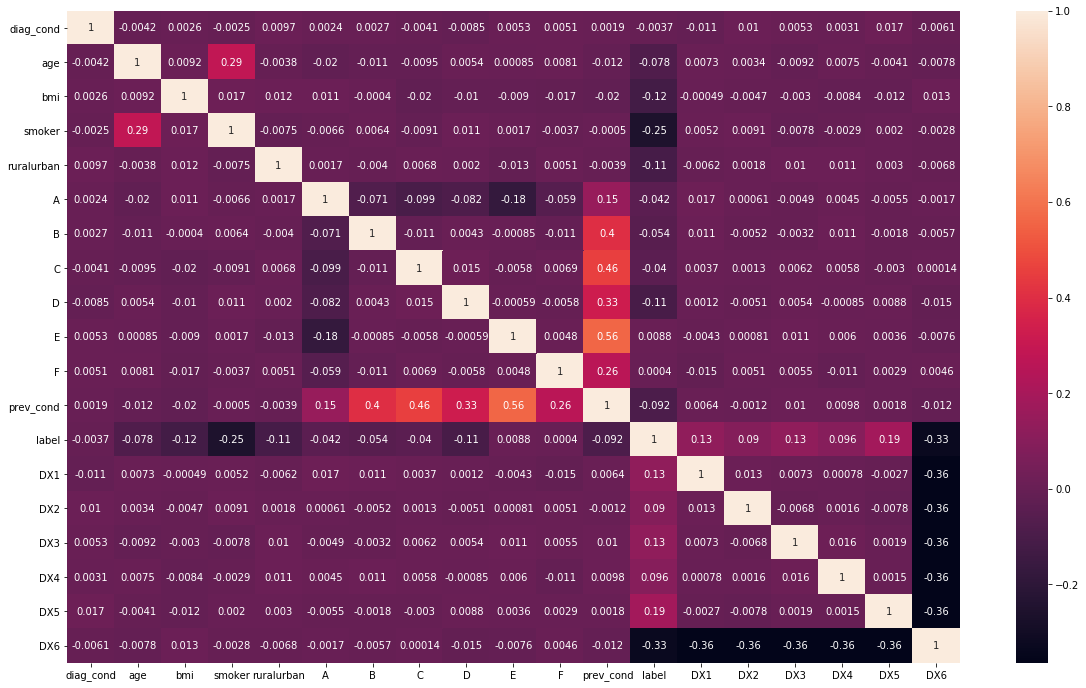

In [86]:
plt.figure(figsize=(20,12))
sns.heatmap(pharma_data.corr(),annot=True)
plt.show()

    1. We already know that prev_cond= Sum of A to F, have the some correlation among them. Also the DX6 has correlation with others 5 drugs.
    2. Apart from that none of the variables have significant relation among dependent variables. 
    3. Coming to the relation with Y, except smoker and DX6 (that too very less negative corr), none have any significant relation.

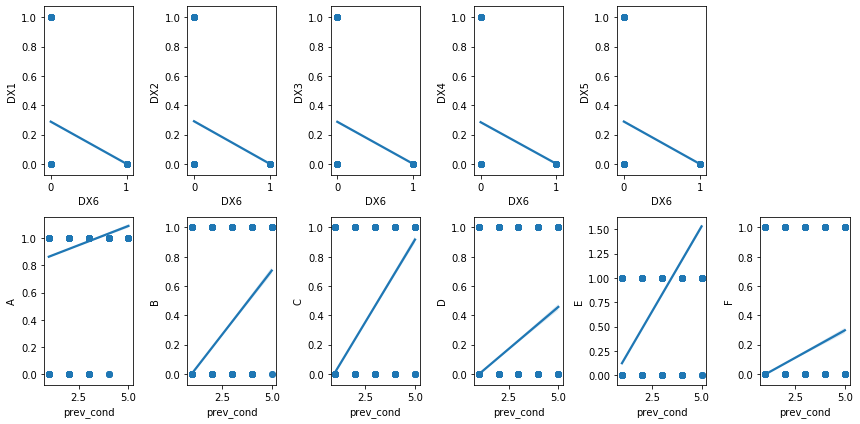

In [109]:
plt.figure(figsize=(12,6))
plt.subplot(2,6,1)
sns.regplot(pharma_data.DX6,pharma_data.DX1)
plt.subplot(2,6,2)
sns.regplot(pharma_data.DX6,pharma_data.DX2)
plt.subplot(2,6,3)
sns.regplot(pharma_data.DX6,pharma_data.DX3)
plt.subplot(2,6,4)
sns.regplot(pharma_data.DX6,pharma_data.DX4)
plt.subplot(2,6,5)
sns.regplot(pharma_data.DX6,pharma_data.DX5)
plt.subplot(2,6,7)
sns.regplot(pharma_data.prev_cond,pharma_data.A)
plt.subplot(2,6,8)
sns.regplot(pharma_data.prev_cond,pharma_data.B)
plt.subplot(2,6,9)
sns.regplot(pharma_data.prev_cond,pharma_data.C)
plt.subplot(2,6,10)
sns.regplot(pharma_data.prev_cond,pharma_data.D)
plt.subplot(2,6,11)
sns.regplot(pharma_data.prev_cond,pharma_data.E)
plt.subplot(2,6,12)
sns.regplot(pharma_data.prev_cond,pharma_data.F)
plt.tight_layout()
plt.show()

##### Scale the X values

In [110]:
X_scaled=pharma_data.drop('label',axis=1)
y=pharma_data.label
print(X_scaled.shape,y.shape,test_new.shape)

from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_scaled=pd.DataFrame(ss.fit_transform(X_scaled),columns=X_scaled.columns)
test_new_scaled=pd.DataFrame(ss.transform(test_new),columns=test_new.columns)
print(X_scaled.shape,y.shape,test_new_scaled.shape)
X_scaled.head()

(23084, 18) (23084,) (9303, 18)
(23084, 18) (23084,) (9303, 18)


,diag_cond,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond,DX1,DX2,DX3,DX4,DX5,DX6
0,-1.226759,1.175949,-1.322008,1.160350,1.521591,0.326114,-0.38508,-0.461001,-0.293256,1.298123,-0.23148,0.376512,-0.469407,-0.472222,-0.468444,-0.465898,-0.470025,1.297041
1,-1.426471,0.146363,-0.138251,1.160350,-0.657207,0.326114,-0.38508,-0.461001,-0.293256,-0.770343,-0.23148,-0.925180,-0.469407,2.117649,-0.468444,-0.465898,-0.470025,-0.770986
2,-0.228203,0.764115,1.071555,1.160350,-0.657207,0.326114,-0.38508,-0.461001,-0.293256,-0.770343,-0.23148,-0.925180,-0.469407,-0.472222,-0.468444,-0.465898,-0.470025,1.297041
3,1.635768,-1.449496,-1.149305,-0.861809,1.521591,0.326114,-0.38508,-0.461001,-0.293256,-0.770343,-0.23148,-0.925180,2.130349,-0.472222,-0.468444,-0.465898,-0.470025,-0.770986
4,1.236345,0.712635,0.712438,1.160350,1.521591,0.326114,-0.38508,-0.461001,-0.293256,-0.770343,-0.23148,-0.925180,-0.469407,-0.472222,-0.468444,-0.465898,-0.470025,1.297041


In [111]:
test_new_scaled.head()

,diag_cond,age,bmi,smoker,ruralurban,A,B,C,D,E,F,prev_cond,DX1,DX2,DX3,DX4,DX5,DX6
0,0.903493,-0.883224,1.584124,-0.861809,-0.657207,0.326114,-0.385080,-0.461001,-0.293256,1.298123,-0.23148,0.376512,-0.469407,-0.472222,2.134726,-0.465898,-0.470025,-0.770986
1,1.702338,-0.471389,0.892990,-0.861809,1.521591,0.326114,2.596865,-0.461001,-0.293256,-0.770343,-0.23148,0.376512,-0.469407,-0.472222,-0.468444,-0.465898,-0.470025,1.297041
2,1.569197,1.536305,0.544969,-0.861809,-0.657207,0.326114,-0.385080,-0.461001,-0.293256,1.298123,-0.23148,0.376512,-0.469407,-0.472222,-0.468444,2.146391,2.127547,-0.770986
3,0.370930,0.455239,0.981737,-0.861809,1.521591,0.326114,-0.385080,2.169191,-0.293256,1.298123,-0.23148,1.678203,-0.469407,-0.472222,-0.468444,-0.465898,-0.470025,1.297041
4,-0.427915,0.867073,0.553693,-0.861809,-0.657207,0.326114,-0.385080,-0.461001,-0.293256,-0.770343,-0.23148,-0.925180,-0.469407,-0.472222,2.134726,-0.465898,-0.470025,-0.770986


#### Split into Train and test data.

In [112]:
from sklearn.model_selection import train_test_split
X_scaled_train,X_scaled_test,y_train,y_test=train_test_split(X_scaled,y,test_size=0.2,random_state=78)
print(X_scaled_train.shape,X_scaled_test.shape,y_train.shape,y_test.shape)

(18467, 18) (4617, 18) (18467,) (4617,)


##### Create an empty DataFrame for recording metrics of various models

In [113]:
### Final Metric Table
Final_metrics=pd.DataFrame(columns=['f1_train','f1_test','f1_Test_New','acc_train','acc_test'])
Final_metrics

,f1_train,f1_test,f1_Test_New,acc_train,acc_test


### Model Building and Evaluation:
Various classification algoithms where tested and tuned parameters manually. Grid Search is of an expensive thing and also the best params are listed with respect to the test data, which we have made from Training Dataset and these may not be best against the actual (hidden) test data. So Grid Search is not used instead manually tuned keeping one param variable and others constant.

#### Logistic Regression model (Base Model)

In [114]:
from sklearn.linear_model import LogisticRegression
model_lr=LogisticRegression().fit(X_scaled_train,y_train)
print(model_lr)

y_pred_train=model_lr.predict(X_scaled_train)
y_pred_test=model_lr.predict(X_scaled_test)

from sklearn.metrics import f1_score,accuracy_score
f1_train=f1_score(y_train,y_pred_train) * 100
f1_test=f1_score(y_test,y_pred_test) * 100
acc_train=accuracy_score(y_train,y_pred_train) * 100
acc_test=accuracy_score(y_test,y_pred_test) * 100
print(list(model_lr.predict(test_new_scaled)))

Final_metrics=Final_metrics.append(pd.DataFrame({'f1_train':[f1_train],\
                                                 'f1_test':[f1_test],\
                                                 'acc_train':[acc_train],\
                                                 'acc_test':[acc_test]},\
                                                index=['LogisticRegression']))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1

In [115]:
Final_metrics.loc['LogisticRegression','f1_Test_New']=79.220361
Final_metrics

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143


#### AdaBoost Classifier

In [116]:
from sklearn.ensemble import AdaBoostClassifier
adab = AdaBoostClassifier(learning_rate=1.2,n_estimators=200,random_state=1)
adab.fit(X_scaled_train,y_train);print(adab)

y_pred_train=adab.predict(X_scaled_train)
y_pred_test=adab.predict(X_scaled_test)

from sklearn.metrics import f1_score,accuracy_score
f1_train=f1_score(y_train,y_pred_train) * 100
f1_test=f1_score(y_test,y_pred_test) * 100
acc_train=accuracy_score(y_train,y_pred_train) * 100
acc_test=accuracy_score(y_test,y_pred_test) * 100
print(list(adab.predict(test_new_scaled)))

Final_metrics=Final_metrics.append(pd.DataFrame({'f1_train':[f1_train],\
                                                 'f1_test':[f1_test],\
                                                 'acc_train':[acc_train],\
                                                 'acc_test':[acc_test]},\
                                                index=['Adaboost_1.2_200']))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.2,
                   n_estimators=200, random_state=1)
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0,

In [117]:
Final_metrics.loc['Adaboost_1.2_200','f1_Test_New']=85.039108
Final_metrics

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143
Adaboost_1.2_200,86.059248,85.685752,85.0391,81.805383,81.373186


##### Gradient Boosting Classifier

In [118]:
from sklearn.ensemble import GradientBoostingClassifier

GBC= GradientBoostingClassifier(learning_rate=0.501,random_state=1,n_estimators=125)
GBC.fit(X_scaled_train,y_train);print(GBC)

y_pred_train=GBC.predict(X_scaled_train)
y_pred_test=GBC.predict(X_scaled_test)

from sklearn.metrics import f1_score,accuracy_score
f1_train=f1_score(y_train,y_pred_train) * 100
f1_test=f1_score(y_test,y_pred_test) * 100
acc_train=accuracy_score(y_train,y_pred_train) * 100
acc_test=accuracy_score(y_test,y_pred_test) * 100
print('f1_train:',f1_train,'\tacc_train:',acc_train,'\nf1_test:',f1_test,'\tacc_test:',acc_test)
print(list(GBC.predict(test_new_scaled)))

Final_metrics=Final_metrics.append(pd.DataFrame({'f1_train':[f1_train],\
                                                 'f1_test':[f1_test],\
                                                 'acc_train':[acc_train],\
                                                 'acc_test':[acc_test]},\
                                                index=['GradientBoosting_0.5_125']))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.501, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=125,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)
f1_train: 89.5700871615647 	acc_train: 86.58688471327233 
f1_test: 86.95359784801614 	acc_test: 83.19254927442063
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 

In [119]:
Final_metrics.loc['GradientBoosting_0.5_125','f1_Test_New']=87.159599
Final_metrics

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143
Adaboost_1.2_200,86.059248,85.685752,85.0391,81.805383,81.373186
GradientBoosting_0.5_125,89.570087,86.953598,87.1596,86.586885,83.192549


##### Gradient Boosting with different params

In [120]:
GBC= GradientBoostingClassifier(learning_rate=0.20001,random_state=1,n_estimators=125,max_depth=4)
GBC.fit(X_scaled_train,y_train);print(GBC)

y_pred_train=GBC.predict(X_scaled_train)
y_pred_test=GBC.predict(X_scaled_test)

from sklearn.metrics import f1_score,accuracy_score
f1_train=f1_score(y_train,y_pred_train) * 100
f1_test=f1_score(y_test,y_pred_test) * 100
acc_train=accuracy_score(y_train,y_pred_train) * 100
acc_test=accuracy_score(y_test,y_pred_test) * 100

print('\nf1_train:',f1_train,'\tacc_train:',acc_train,'\nf1_test:',f1_test,'\tacc_test:',acc_test)
print(list(GBC.predict(test_new_scaled)))

#learning_rate=0.20001,random_state=1,n_estimators=125,max_depth=4
#learning_rate=0.31,random_state=1,n_estimators=125
Final_metrics=Final_metrics.append(pd.DataFrame({'f1_train':[f1_train],\
                                                 'f1_test':[f1_test],\
                                                 'acc_train':[acc_train],\
                                                 'acc_test':[acc_test]},\
                                                index=['GradientBoosting_0.2_125_4']))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.20001, loss='deviance', max_depth=4,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=125,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

f1_train: 89.73122562790893 	acc_train: 86.73850652515299 
f1_test: 87.17518860016766 	acc_test: 83.4307992202729
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 

In [121]:
Final_metrics.loc['GradientBoosting_0.2_125_4','f1_Test_New']=87.411646
Final_metrics

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143
Adaboost_1.2_200,86.059248,85.685752,85.0391,81.805383,81.373186
GradientBoosting_0.5_125,89.570087,86.953598,87.1596,86.586885,83.192549
GradientBoosting_0.2_125_4,89.731226,87.175189,87.4116,86.738507,83.430799


##### As we know that 'prev_cond' is equal to 'A+B+C..+F', we shall remove this variable and try out different models

In [122]:
X_scaled_train_pc=X_scaled_train.drop('prev_cond',axis=1)
X_scaled_test_pc=X_scaled_test.drop('prev_cond',axis=1)
test_new_scaled_pc=test_new_scaled.drop('prev_cond',axis=1)

##### Adaboost Classifier

In [123]:
from sklearn.ensemble import AdaBoostClassifier
adab = AdaBoostClassifier(learning_rate=0.3,n_estimators=125,random_state=1)
adab.fit(X_scaled_train_pc,y_train);print(adab)

y_pred_train=adab.predict(X_scaled_train_pc)
y_pred_test=adab.predict(X_scaled_test_pc)

from sklearn.metrics import f1_score,accuracy_score
f1_train=f1_score(y_train,y_pred_train) * 100
f1_test=f1_score(y_test,y_pred_test) * 100
acc_train=accuracy_score(y_train,y_pred_train) * 100
acc_test=accuracy_score(y_test,y_pred_test) * 100
print('\nf1_train:',f1_train,'\tacc_train:',acc_train,'\nf1_test:',f1_test,'\tacc_test:',acc_test)
print(list(adab.predict(test_new_scaled_pc)))

Final_metrics=Final_metrics.append(pd.DataFrame({'f1_train':[f1_train],\
                                                 'f1_test':[f1_test],\
                                                 'acc_train':[acc_train],\
                                                 'acc_test':[acc_test]},\
                                                index=['Adaboost_0.3_125']))

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=0.3,
                   n_estimators=125, random_state=1)

f1_train: 85.84463725610004 	acc_train: 81.18265013266908 
f1_test: 86.02748691099477 	acc_test: 81.50314056746805
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 

In [124]:
Final_metrics.loc['Adaboost_0.3_125','f1_Test_New']=85.259809
Final_metrics

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143
Adaboost_1.2_200,86.059248,85.685752,85.0391,81.805383,81.373186
GradientBoosting_0.5_125,89.570087,86.953598,87.1596,86.586885,83.192549
GradientBoosting_0.2_125_4,89.731226,87.175189,87.4116,86.738507,83.430799
Adaboost_0.3_125,85.844637,86.027487,85.2598,81.182650,81.503141


##### Lets try out BORUTA to know important features and try out with these important features

In [125]:
from boruta import BorutaPy
boruta_selector = BorutaPy(GBC, n_estimators='auto', verbose=2, random_state=1)
boruta_selector.fit(np.array(X_scaled_train_pc), np.array(y_train))

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	6
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	6
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	6
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	6
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	7


BorutaPy finished running.

Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	0
Rejected: 	7


BorutaPy(alpha=0.05,
         estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                              criterion='friedman_mse',
                                              init=None, learning_rate=0.20001,
                                              loss='deviance', max_depth=4,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=117,
                                              n_iter_no_change=None,
                                              presort='deprecated',
    

In [126]:
# check selected features
print("Selected Features: ", boruta_selector.support_)
 
# check ranking of features
print("Ranking: ",boruta_selector.ranking_)

print("No. of significant features: ", boruta_selector.n_features_)

# Let's visualise it better in the form of a table
selected_rfe_features = pd.DataFrame({'Feature':list(X_scaled_train_pc.columns),
                                      'Ranking':boruta_selector.ranking_})
selected_rfe_features.sort_values(by='Ranking').head(20)

Selected Features:  [ True  True  True  True  True  True False  True  True False False False
 False False False  True  True]
Ranking:  [1 1 1 1 1 1 4 1 1 7 8 3 6 5 2 1 1]
No. of significant features:  10


,Feature,Ranking
0,diag_cond,1
15,DX5,1
7,C,1
5,A,1
8,D,1
3,smoker,1
2,bmi,1
1,age,1
4,ruralurban,1
16,DX6,1


In [127]:
X_important_train = boruta_selector.transform(np.array(X_scaled_train_pc))
X_important_test = boruta_selector.transform(np.array(X_scaled_test_pc))
X_important_test_new = boruta_selector.transform(np.array(test_new_scaled_pc))

modelB= GradientBoostingClassifier(learning_rate=0.3,random_state=1,n_estimators=150)
# model2= GradientBoostingClassifier(learning_rate=0.2,random_state=1,n_estimators=125)
modelB.fit(X_important_train,y_train);print(modelB)

y_pred_train=modelB.predict(X_important_train)
y_pred_test=modelB.predict(X_important_test)

from sklearn.metrics import f1_score,accuracy_score
f1_train=f1_score(y_train,y_pred_train) * 100
f1_test=f1_score(y_test,y_pred_test) * 100
acc_train=accuracy_score(y_train,y_pred_train) * 100
acc_test=accuracy_score(y_test,y_pred_test) * 100

print('\nf1_train:',f1_train,'\tacc_train:',acc_train,'\nf1_test:',f1_test,'\tacc_test:',acc_test)
print(list(modelB.predict(X_important_test_new)))

Final_metrics=Final_metrics.append(pd.DataFrame({'f1_train':[f1_train],\
                                                 'f1_test':[f1_test],\
                                                 'acc_train':[acc_train],\
                                                 'acc_test':[acc_test]},\
                                                index=['Boruta_GradientBoosting_0.3_150']))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.3, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=150,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

f1_train: 88.17869990797288 	acc_train: 84.69702712947421 
f1_test: 85.96784996651039 	acc_test: 81.84968594325319
[1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 

In [128]:
Final_metrics.loc['Boruta_GradientBoosting_0.3_150','f1_Test_New']=85.819583
Final_metrics

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143
Adaboost_1.2_200,86.059248,85.685752,85.0391,81.805383,81.373186
GradientBoosting_0.5_125,89.570087,86.953598,87.1596,86.586885,83.192549
GradientBoosting_0.2_125_4,89.731226,87.175189,87.4116,86.738507,83.430799
Adaboost_0.3_125,85.844637,86.027487,85.2598,81.182650,81.503141
Boruta_GradientBoosting_0.3_150,88.178700,85.967850,85.8196,84.697027,81.849686


##### Gradient Boosting

In [129]:
GBC= GradientBoostingClassifier(learning_rate=0.28,random_state=1,n_estimators=125)
GBC.fit(X_scaled_train_pc,y_train);print(GBC)

y_pred_train=GBC.predict(X_scaled_train_pc)
y_pred_test=GBC.predict(X_scaled_test_pc)

from sklearn.metrics import f1_score,accuracy_score
f1_train=f1_score(y_train,y_pred_train) * 100
f1_test=f1_score(y_test,y_pred_test) * 100
acc_train=accuracy_score(y_train,y_pred_train) * 100
acc_test=accuracy_score(y_test,y_pred_test) * 100

print('\nf1_train:',f1_train,'\tacc_train:',acc_train,'\nf1_test:',f1_test,'\tacc_test:',acc_test)
print(list(GBC.predict(test_new_scaled_pc)))

#learning_rate=0.28,random_state=1,n_estimators=125; X_scaled_train_pc
#learning_rate=0.20001,random_state=1,n_estimators=125,max_depth=4
#learning_rate=0.31,random_state=1,n_estimators=125
Final_metrics=Final_metrics.append(pd.DataFrame({'f1_train':[f1_train],\
                                                 'f1_test':[f1_test],\
                                                 'acc_train':[acc_train],\
                                                 'acc_test':[acc_test]},\
                                                index=['GradientBoosting_0.28_125']))

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.28, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=125,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

f1_train: 88.95584850387111 	acc_train: 85.70964423024854 
f1_test: 87.33433987585975 	acc_test: 83.64739008013862
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0,

In [130]:
Final_metrics.loc['GradientBoosting_0.28_125','f1_Test_New']=87.541862
Final_metrics

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143
Adaboost_1.2_200,86.059248,85.685752,85.0391,81.805383,81.373186
GradientBoosting_0.5_125,89.570087,86.953598,87.1596,86.586885,83.192549
GradientBoosting_0.2_125_4,89.731226,87.175189,87.4116,86.738507,83.430799
Adaboost_0.3_125,85.844637,86.027487,85.2598,81.182650,81.503141
Boruta_GradientBoosting_0.3_150,88.178700,85.967850,85.8196,84.697027,81.849686
GradientBoosting_0.28_125,88.955849,87.334340,87.5419,85.709644,83.647390


##### XG Boost Classifier

In [323]:
from xgboost import XGBClassifier
# fit model to training data
xgb_model = XGBClassifier(learning_rate=0.3,n_estimators=114,random_state = 1,max_depth=3)
xgb_model.fit(X_scaled_train_pc,y_train);print(xgb_model)

y_pred_train=xgb_model.predict(X_scaled_train_pc)
y_pred_test=xgb_model.predict(X_scaled_test_pc)

from sklearn.metrics import f1_score,accuracy_score
f1_train=f1_score(y_train,y_pred_train) * 100
f1_test=f1_score(y_test,y_pred_test) * 100
acc_train=accuracy_score(y_train,y_pred_train) * 100
acc_test=accuracy_score(y_test,y_pred_test) * 100

print('\nf1_train:',f1_train,'\tacc_train:',acc_train,'\nf1_test:',f1_test,'\tacc_test:',acc_test)
print(list(xgb_model.predict(test_new_scaled_pc)))
#learning_rate=0.3,n_estimators=114,random_state = 0,max_depth=3

Final_metrics=Final_metrics.append(pd.DataFrame({'f1_train':[f1_train],\
                                                 'f1_test':[f1_test],\
                                                 'acc_train':[acc_train],\
                                                 'acc_test':[acc_test]},\
                                                index=['XGBoosting_0.3_114_3']))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=114, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

f1_train: 88.83487007544007 	acc_train: 85.57426761249796 
f1_test: 87.49790233260615 	acc_test: 83.86398094000434
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,

In [324]:
Final_metrics.loc['XGBoosting_0.3_114_3','f1_Test_New']=87.549324
Final_metrics

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143
Adaboost_1.2_200,86.059248,85.685752,85.0391,81.805383,81.373186
GradientBoosting_0.5_125,89.570087,86.953598,87.1596,86.586885,83.192549
GradientBoosting_0.2_125_4,89.731226,87.175189,87.4116,86.738507,83.430799
Adaboost_0.3_125,85.844637,86.027487,85.2598,81.182650,81.503141
Boruta_GradientBoosting_0.3_150,88.178700,85.967850,85.8196,84.697027,81.849686
GradientBoosting_0.28_125,88.955849,87.334340,87.5419,85.709644,83.647390
XGBoosting_0.3_114_3,88.834870,87.497902,87.5493,85.574268,83.863981


In [326]:
Final_metrics.sort_values('f1_Test_New',ascending=False)

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
XGBoosting_0.3_114_3,88.834870,87.497902,87.5493,85.574268,83.863981
GradientBoosting_0.28_125,88.955849,87.334340,87.5419,85.709644,83.647390
GradientBoosting_0.2_125_4,89.731226,87.175189,87.4116,86.738507,83.430799
GradientBoosting_0.5_125,89.570087,86.953598,87.1596,86.586885,83.192549
Boruta_GradientBoosting_0.3_150,88.178700,85.967850,85.8196,84.697027,81.849686
Adaboost_0.3_125,85.844637,86.027487,85.2598,81.182650,81.503141
Adaboost_1.2_200,86.059248,85.685752,85.0391,81.805383,81.373186
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143


### Custom Grid Search:
For different Learning rates, # of trees and depth, we shall record f1 score on test_data and try to get to the best f1 on hidden test records.

In [153]:
LR=list(np.round(np.linspace(0.01,0.99,20),2));LR
n_est=list(range(50,251,25));n_est
depth=[3,4,5,6];depth

[3, 4, 5, 6]

In [307]:
XGB_iterations=pd.DataFrame(columns=['lr','n_est','depth','f1_train','f1_test','f1_Test_New','acc_train','acc_test'])
XGB_iterations

,lr,n_est,depth,f1_train,f1_test,f1_Test_New,acc_train,acc_test


In [330]:
for lr in LR:
    for est in n_est:
        for dep in depth:
            xgb_model = XGBClassifier(random_state = 1,learning_rate=lr,n_estimators=est,max_depth=dep)
            xgb_model.fit(X_scaled_train_pc,y_train)#;print(xgb_model)
            
            y_pred_train=xgb_model.predict(X_scaled_train_pc)
            y_pred_test=xgb_model.predict(X_scaled_test_pc)
            
            f1_train=f1_score(y_train,y_pred_train) * 100
            f1_test=f1_score(y_test,y_pred_test) * 100
            acc_train=accuracy_score(y_train,y_pred_train) * 100
            acc_test=accuracy_score(y_test,y_pred_test) * 100
            indname=str(lr)+'_'+str(est)+'_'+str(dep)
            print(indname,':\n')
#             print('\nf1_train:',f1_train,'\tacc_train:',acc_train,'\nf1_test:',f1_test,'\tacc_test:',acc_test)
            print(list(xgb_model.predict(test_new_scaled_pc)))
            XGB_iterations=XGB_iterations.append(pd.DataFrame({'lr':[lr],\
                                                               'n_est':[est],\
                                                               'depth':[dep],\
                                                               'f1_train':[f1_train],\
                                                               'f1_test':[f1_test],\
                                                               'acc_train':[acc_train],\
                                                               'acc_test':[acc_test]},\
                                                              index=[indname]))
        break
    break

0.01_50_3 :

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,

0.01_50_4 :

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,

0.01_50_5 :

[1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0,

0.01_50_6 :

[1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,

In [311]:
XGB_iterations

,lr,n_est,depth,f1_train,f1_test,f1_Test_New,acc_train,acc_test
0.01_50_3,0.01,50,3,81.830768,81.738281,NaN,75.837981,75.698506
0.01_50_4,0.01,50,4,82.213663,81.908162,NaN,76.244111,75.850119
0.01_50_5,0.01,50,5,83.297924,82.992975,NaN,77.863215,77.452891
0.01_50_6,0.01,50,6,84.567085,84.356895,NaN,79.769318,79.532164
0.01_75_3,0.01,75,3,81.815922,81.888981,NaN,76.227866,76.326619
...,...,...,...,...,...,...,...,...
0.99_225_6,0.99,225,6,99.841603,85.563500,NaN,99.799643,81.633095
0.99_250_3,0.99,250,3,92.435550,86.650734,NaN,90.339525,83.062595
0.99_250_4,0.99,250,4,95.837235,86.010187,NaN,94.704067,82.152913
0.99_250_5,0.99,250,5,98.970041,85.265494,NaN,98.694969,81.308209


In [315]:
XGB_iterations.sort_values(by=['f1_test','acc_test'],ascending=False).to_csv('XGB_iterations1.csv')
XGB_iterations.sort_values(by=['f1_test','acc_test'],ascending=False).head()

,lr,n_est,depth,f1_train,f1_test,f1_Test_New,acc_train,acc_test
0.32_100_4,0.32,100,4,89.988628,87.832828,NaN,87.128391,84.362140
0.06_175_4,0.06,175,4,88.475346,87.776677,NaN,84.875724,83.972276
0.06_200_4,0.06,200,4,88.651690,87.717553,NaN,85.146478,83.950617
0.16_75_4,0.16,75,4,88.693415,87.693074,NaN,85.243949,83.950617
0.16_250_4,0.16,250,4,90.282633,87.645373,NaN,87.507446,84.123890


In [317]:
XGB_iterations.loc['0.06_200_4','f1_Test_New']=87.563346
XGB_iterations.loc['0.11_100_4','f1_Test_New']=87.521822
XGB_iterations.loc['0.06_225_4','f1_Test_New']=87.503122
XGB_iterations.loc['0.06_175_4','f1_Test_New']=87.498965
XGB_iterations.loc['0.06_250_5','f1_Test_New']=87.455681
XGB_iterations.loc['0.37_50_4','f1_Test_New']=87.448577
XGB_iterations.loc['0.11_150_5','f1_Test_New']=87.445157
XGB_iterations.loc['0.37_75_3','f1_Test_New']=87.43803
XGB_iterations.loc['0.27_150_3','f1_Test_New']=87.433718
XGB_iterations.loc['0.06_225_5','f1_Test_New']=87.432615
XGB_iterations.loc['0.16_150_3','f1_Test_New']=87.408897
XGB_iterations.loc['0.22_150_3','f1_Test_New']=87.40778
XGB_iterations.loc['0.47_50_4','f1_Test_New']=87.405414
XGB_iterations.loc['0.16_125_4','f1_Test_New']=87.40442
XGB_iterations.loc['0.32_50_4','f1_Test_New']=87.400586
XGB_iterations.loc['0.47_50_3','f1_Test_New']=87.39834
XGB_iterations.loc['0.11_175_5','f1_Test_New']=87.384875
XGB_iterations.loc['0.06_150_4','f1_Test_New']=87.384412
XGB_iterations.loc['0.27_100_3','f1_Test_New']=87.38188
XGB_iterations.loc['0.16_225_4','f1_Test_New']=87.377492
XGB_iterations.loc['0.47_175_3','f1_Test_New']=87.377327
XGB_iterations.loc['0.22_125_3','f1_Test_New']=87.371156
XGB_iterations.loc['0.16_225_3','f1_Test_New']=87.367714
XGB_iterations.loc['0.16_75_4','f1_Test_New']=87.366667
XGB_iterations.loc['0.16_175_3','f1_Test_New']=87.361531
XGB_iterations.loc['0.16_50_4','f1_Test_New']=87.350441
XGB_iterations.loc['0.22_50_4','f1_Test_New']=87.340009
XGB_iterations.loc['0.27_50_5','f1_Test_New']=87.320151
XGB_iterations.loc['0.32_125_4','f1_Test_New']=87.313244
XGB_iterations.loc['0.32_75_3','f1_Test_New']=87.302918
XGB_iterations.loc['0.32_75_4','f1_Test_New']=87.302
XGB_iterations.loc['0.11_200_5','f1_Test_New']=87.301991
XGB_iterations.loc['0.16_250_4','f1_Test_New']=87.28656
XGB_iterations.loc['0.16_200_4','f1_Test_New']=87.259595
XGB_iterations.loc['0.22_100_3','f1_Test_New']=87.258752
XGB_iterations.loc['0.11_250_3','f1_Test_New']=87.25203
XGB_iterations.loc['0.32_150_4','f1_Test_New']=87.243563
XGB_iterations.loc['0.32_150_4','f1_Test_New']=87.243563
XGB_iterations.loc['0.32_150_3','f1_Test_New']=87.238159
XGB_iterations.loc['0.32_225_3','f1_Test_New']=87.22973
XGB_iterations.loc['0.11_200_3','f1_Test_New']=87.228715
XGB_iterations.loc['0.78_100_3','f1_Test_New']=87.224521
XGB_iterations.loc['0.27_75_5','f1_Test_New']=87.206355
XGB_iterations.loc['0.11_225_3','f1_Test_New']=87.193643
XGB_iterations.loc['0.16_150_5','f1_Test_New']=87.193368
XGB_iterations.loc['0.32_100_3','f1_Test_New']=87.193277
XGB_iterations.loc['0.06_125_4','f1_Test_New']=87.183714
XGB_iterations.loc['0.32_250_3','f1_Test_New']=87.155653
XGB_iterations.loc['0.32_100_4','f1_Test_New']=87.155267
XGB_iterations.loc['0.16_50_5','f1_Test_New']=87.146551
XGB_iterations.loc['0.89_50_3','f1_Test_New']=87.139596
XGB_iterations.loc['0.42_50_3','f1_Test_New']=87.121722
XGB_iterations.loc['0.11_175_3','f1_Test_New']=87.093547
XGB_iterations.loc['0.22_75_3','f1_Test_New']=87.081738
XGB_iterations.loc['0.16_100_3','f1_Test_New']=87.064304
XGB_iterations.loc['0.16_200_5','f1_Test_New']=87.059621
XGB_iterations.loc['0.16_125_3','f1_Test_New']=87.048193
XGB_iterations.loc['0.11_50_5','f1_Test_New']=87.031509
XGB_iterations.loc['0.06_100_5','f1_Test_New']=87.025552
XGB_iterations.loc['0.32_50_3','f1_Test_New']=87.025448
XGB_iterations.loc['0.32_75_6','f1_Test_New']=87.006607
XGB_iterations.loc['0.11_150_3','f1_Test_New']=87.006497
XGB_iterations.loc['0.22_50_3','f1_Test_New']=86.955803
XGB_iterations.loc['0.27_50_3','f1_Test_New']=86.762996
XGB_iterations.loc['0.06_75_5','f1_Test_New']=86.725664
XGB_iterations.loc['0.01_250_6','f1_Test_New']=86.371856
XGB_iterations.loc['0.01_250_6','f1_Test_New']=86.371856
XGB_iterations.loc['0.01_225_6','f1_Test_New']=86.220763
XGB_iterations.loc['0.99_250_3','f1_Test_New']=86.085406
XGB_iterations.loc['0.99_250_6','f1_Test_New']=84.84
XGB_iterations.loc['0.01_50_3','f1_Test_New']=81.15942

In [318]:
XGB_iterations.sort_values('f1_Test_New',ascending=False)

,lr,n_est,depth,f1_train,f1_test,f1_Test_New,acc_train,acc_test
0.06_200_4,0.06,200,4,88.651690,87.717553,87.5633,85.146478,83.950617
0.11_100_4,0.11,100,4,88.547532,87.502075,87.5218,85.021931,83.690708
0.06_225_4,0.06,225,4,88.867682,87.556072,87.5031,85.471381,83.777345
0.06_175_4,0.06,175,4,88.475346,87.776677,87.499,84.875724,83.972276
0.06_250_5,0.06,250,5,89.955929,87.548311,87.4557,87.041750,83.950617
...,...,...,...,...,...,...,...,...
0.99_225_4,0.99,225,4,95.405279,85.904210,NaN,94.146315,82.087936
0.99_225_5,0.99,225,5,98.625811,85.392491,NaN,98.256349,81.459822
0.99_225_6,0.99,225,6,99.841603,85.563500,NaN,99.799643,81.633095
0.99_250_4,0.99,250,4,95.837235,86.010187,NaN,94.704067,82.152913


### My personal best Submission:

In [327]:
from xgboost import XGBClassifier
# fit model to training data
xgb_model = XGBClassifier(learning_rate=0.06,n_estimators=199,random_state = 1,max_depth=4)
xgb_model.fit(X_scaled_train_pc,y_train);print(xgb_model)

y_pred_train=xgb_model.predict(X_scaled_train_pc)
y_pred_test=xgb_model.predict(X_scaled_test_pc)

from sklearn.metrics import f1_score,accuracy_score
f1_train=f1_score(y_train,y_pred_train) * 100
f1_test=f1_score(y_test,y_pred_test) * 100
acc_train=accuracy_score(y_train,y_pred_train) * 100
acc_test=accuracy_score(y_test,y_pred_test) * 100

print('\nf1_train:',f1_train,'\tacc_train:',acc_train,'\nf1_test:',f1_test,'\tacc_test:',acc_test)
Final_metrics=Final_metrics.append(pd.DataFrame({'f1_train':[f1_train],\
                                                 'f1_test':[f1_test],\
                                                 'acc_train':[acc_train],\
                                                 'acc_test':[acc_test]},\
                                                index=['XGBoosting_0.06_199_4']))

Final_metrics.loc['XGBoosting_0.06_199_4','f1_Test_New']=87.576814

predictions=xgb_model.predict(test_new_scaled_pc)
print(list(predictions))

res = pd.DataFrame(predictions) #preditcions are nothing but the final predictions of your model on input features of your new unseen test data
res.index = test_new_scaled_pc.index # its important for comparison. Here "test_new" is your new test dataset
res.columns = ["prediction"]
res.to_csv("prediction_results_HP_NareshElugala.csv")      # the csv file will be saved locally on the same location where this notebook is located.

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.06, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=199, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

f1_train: 88.63796169913554 	acc_train: 85.12481724156603 
f1_test: 87.72162386081193 	acc_test: 83.9506172839506
[1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1,

In [329]:
Final_metrics.sort_values('f1_Test_New',ascending=False)

,f1_train,f1_test,f1_Test_New,acc_train,acc_test
XGBoosting_0.06_199_4,88.637962,87.721624,87.5768,85.124817,83.950617
XGBoosting_0.3_114_3,88.834870,87.497902,87.5493,85.574268,83.863981
GradientBoosting_0.28_125,88.955849,87.334340,87.5419,85.709644,83.647390
GradientBoosting_0.2_125_4,89.731226,87.175189,87.4116,86.738507,83.430799
GradientBoosting_0.5_125,89.570087,86.953598,87.1596,86.586885,83.192549
Boruta_GradientBoosting_0.3_150,88.178700,85.967850,85.8196,84.697027,81.849686
Adaboost_0.3_125,85.844637,86.027487,85.2598,81.182650,81.503141
Adaboost_1.2_200,86.059248,85.685752,85.0391,81.805383,81.373186
LogisticRegression,80.078344,79.890605,79.2204,73.011317,72.926143
